# Sentinel-1 time-series analysis

In [7]:
import os
import numpy as np
# import sarxarray as sxr
import xarray as xr
import matplotlib.pyplot as plt

from scipy.spatial import Delaunay
# To work with sparse matrices when we unwrap
from scipy.sparse import csr_matrix
# To solve the linear set of equations
from scipy.sparse.linalg import lsqr
from scipy.interpolate import griddata

from tqdm import tqdm
from datetime import datetime

from drama import utils



Path location

In [8]:
track = 's1_asc_t088'
path = os.path.join('/Users/isabelslingerland/master AES/year 1/Q4/Lab/AESM402B Earth Observation B-module (202324 Q4) - 5222024 - 350 PM/', track) 
netcdf_file = os.path.join('/Users/isabelslingerland/master AES/year 1/Q4/Lab/AESM402B Earth Observation B-module (202324 Q4) - 5222024 - 350 PM/', ("%s_v2.nc" % track))
s1_stack = xr.load_dataset(netcdf_file,engine="h5netcdf")

# Temporal mean of intensity


In [9]:
print(s1_stack.lon, np.max(s1_stack.lon),  np.min(s1_stack.lat), np.max(s1_stack.lat))


<xarray.DataArray 'lon' (azimuth: 221, range: 898)>
array([[6.4212   , 6.421251 , 6.421305 , ..., 6.4664845, 6.4665375,
        6.466585 ],
       [6.4211736, 6.4212246, 6.421275 , ..., 6.4664483, 6.4665017,
        6.4665523],
       [6.421147 , 6.421198 , 6.421249 , ..., 6.4664054, 6.466459 ,
        6.466512 ],
       ...,
       [6.4138446, 6.4138923, 6.41394  , ..., 6.459138 , 6.4591856,
        6.4592338],
       [6.413806 , 6.4138536, 6.4139013, ..., 6.4591   , 6.459153 ,
        6.4592066],
       [6.4137645, 6.4138117, 6.4138594, ..., 6.4590592, 6.4591126,
        6.459166 ]], dtype=float32)
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 7 ... 213 214 215 216 217 218 219 220
  * range    (range) int64 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897
    lat      (azimuth, range) float32 53.12 53.12 53.12 ... 53.16 53.16 53.16
    lon      (azimuth, range) float32 6.421 6.421 6.421 ... 6.459 6.459 6.459 <xarray.DataArray 'lon' ()>
array(6.46658516) <xarray.DataArr

Mean=17627.908203, std=213482.156250


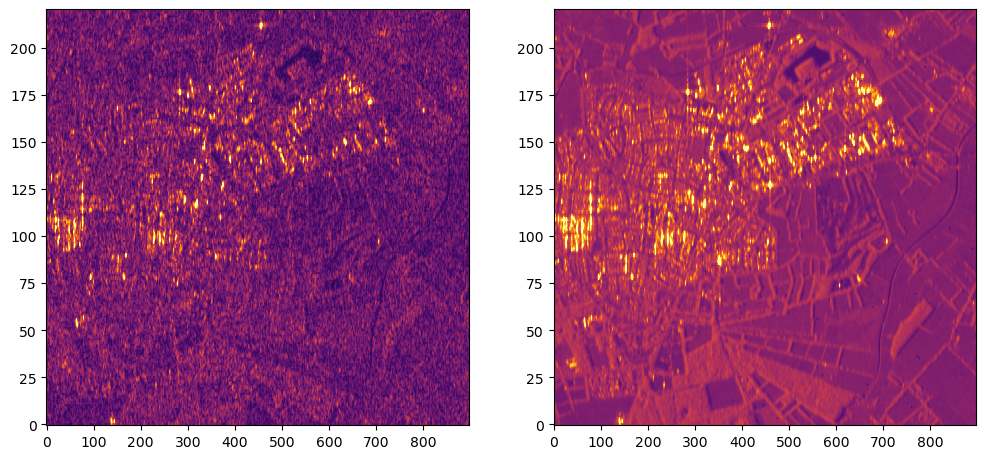

In [10]:
plt.figure(figsize=(12,6))
int0 = np.abs(s1_stack.complex.values[:,:,0])**2
int_tmpavg = np.mean(np.abs(s1_stack.complex.values)**2,axis=2)
mean0 = np.mean(int0)
std0 = np.std(int0)
print("Mean=%f, std=%f" % (mean0, std0))
plt.subplot(1,2,1)
plt.imshow(int0**0.25, origin='lower', aspect=4, vmax=(mean0+2*std0)**0.25, cmap='inferno')
#plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.imshow(int_tmpavg**0.25, origin='lower', aspect=4, vmax=(mean0+1*std0)**0.25, cmap='inferno')

first image mean of one image 
second image mean of all images over time

## Amplitude calibration
We should check that the data is calibrated in amplitude, or trust that it is. One way is to check the mean intensity at different epochs. Calculate and plot the intensity over time, in dB
$$
   I_{dB,i} = 10 \cdot log_{10}\left(\frac{<I>_i}{max_i(<I>_i)}\right)
$$

__Is the amplitude stable?__

(259,)


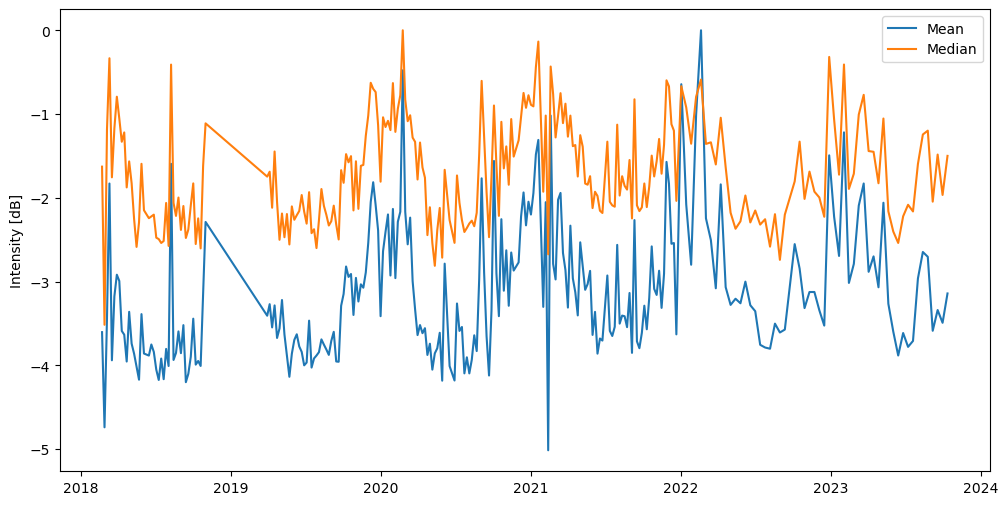

In [11]:
# Make your plot here

int0 = np.abs(s1_stack.complex.values)**2
mean_int= 10*np.log10(np.mean(np.mean(int0,axis=0), axis=0)/np.max(np.mean(np.mean(int0,axis=0), axis=0)))
median_int= 10*np.log10(np.median(np.median(int0,axis=0), axis=0)/np.max(np.median(np.median(int0,axis=0), axis=0)))
t= s1_stack.time.values
plt.figure(figsize=(12,6))
plt.plot(t,mean_int)
plt.plot(t,median_int)
plt.legend(['Mean', 'Median'])
plt.ylabel('Intensity [dB]')
print(mean_int.shape)

If it is not stable enough you should scale the data accordingly. For example, you could divide each image by the square root of the mean intensity
$$
  SLC_{i,cal} = SLC_i/<I>_i
$$
But maybe let us first compute the amplitude dispersion. As seen in class, this is computed as
$$
D_a = \frac{\sigma_a}{m_a}
$$
where $\sigma_a$ and $m_a$ are the standard deviation and mean of the amplitude of each pixel over time, respectively.

__Compute and represent the amplitude dispersion, with and without amplitude calibration__
(Use the code provided for plotting)

/var/folders/9f/qj38cd3d5v37nszw4dsn87nr0000gn/T/ipykernel_71863/3981983105.py:3: RuntimeWarning: invalid value encountered in true_divide
  Da = np.std(stack_amps, axis=-1)/np.mean(stack_amps, axis=-1)


(221, 898)


/var/folders/9f/qj38cd3d5v37nszw4dsn87nr0000gn/T/ipykernel_71863/3981983105.py:7: RuntimeWarning: invalid value encountered in true_divide
  Da_cal = np.std(amp_cal, axis=-1)/np.mean(amp_cal, axis=-1)


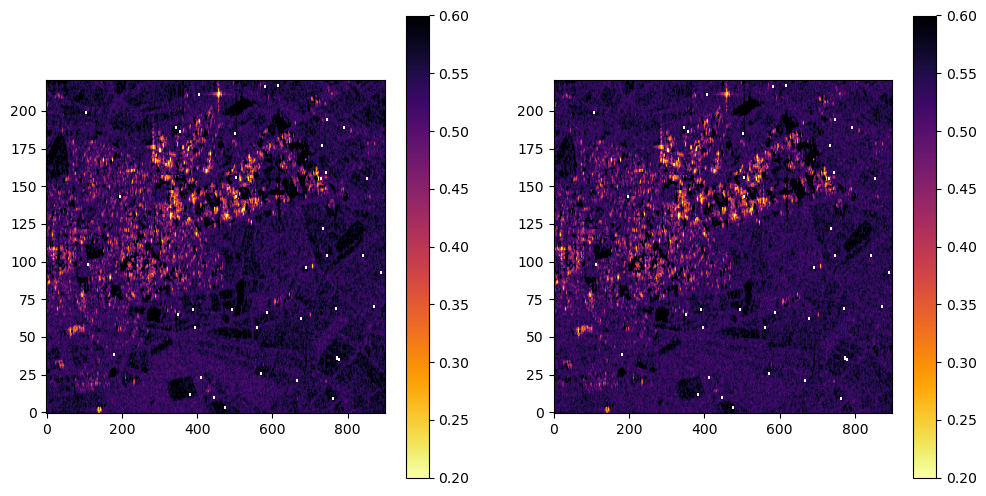

In [12]:
# Compute the amplitude dispersion
stack_amps = np.abs(s1_stack.complex.values)
Da = np.std(stack_amps, axis=-1)/np.mean(stack_amps, axis=-1)
mean_int= np.mean(np.mean(int0,axis=0), axis=0)
amp_cal = stack_amps / np.sqrt(mean_int).reshape((1,1,stack_amps.shape[2]))

Da_cal = np.std(amp_cal, axis=-1)/np.mean(amp_cal, axis=-1)
print(Da_cal.shape)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(Da, origin='lower', aspect=4, cmap='inferno_r',vmin=0.2, vmax=0.6)
plt.colorbar()
#plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.imshow(Da_cal, origin='lower', aspect=4, cmap='inferno_r',vmin=0.2, vmax=0.6)
plt.colorbar()

Now you want to select possible PS by choosing points with $D_a$ below a certain threshold. For this, the `np.where` function is our friend. Find the positions of the PS candiates setting the threshold to 0.25. See how many points we select. Does the calibration make a difference?

(221, 898)
(221, 898)


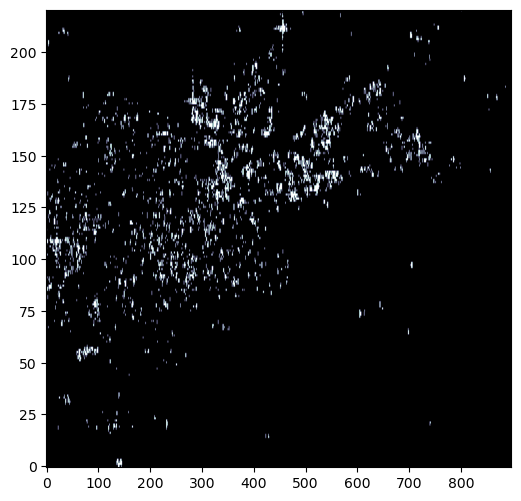

In [20]:
Da_threshold = 0.4
# use np.where to retrieve the positions of the pixels that comply with the amplitude dispersion requirement. 
# if you store them as ps_pos and as ps_cal_pos you will be able to use the code below without renaming variables

plt.figure(figsize=(6,6))
ps_cal_pos= np.where(Da_cal < Da_threshold)
ps_pos= np.where(Da < Da_threshold)
plt.imshow(Da_cal < Da_threshold, origin='lower', aspect=4, cmap='bone')
print(Da_cal.shape)
print((Da_cal < Da_threshold).shape)

Now we triangulate the points using Delaunay. I have created a `tri2arcs` function that extracts unique arcs from the Delaunay triangulation.

In [24]:
points = np.array(ps_cal_pos).T
points.shape
tri = Delaunay(points * np.array([4,1]).reshape((1,2)))
def tri2arcs(dela):
    ntr = dela.simplices.shape[0]
    arcs = np.zeros((ntr,3,2))
    arcs[:,0,0] = dela.simplices[:,0]
    arcs[:,0,1] = dela.simplices[:,1]
    arcs[:,1,0] = dela.simplices[:,1]
    arcs[:,1,1] = dela.simplices[:,2]
    arcs[:,2,0] = dela.simplices[:,2]
    arcs[:,2,1] = dela.simplices[:,0]
    # sort them by last index and then by first
    arcs = arcs.reshape((ntr*3, 2))
    arcs = np.sort(arcs, axis=1)
    dtype = arcs.dtype.descr * 2  # some code found in stackoverflow:
    # https://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array
    struct = arcs.view(dtype)
    uniq = np.unique(struct)
    uniq = uniq.view(arcs.dtype).reshape(-1, 2)
    return uniq

In [25]:
# Unique arcs between points in Delaunay triangulation
arcs = tri2arcs(tri).astype(np.int32)
print(arcs.shape)
# azimuth index  for begin of arc
az_1 = points[arcs[:,0] ,0]
# azimuth index  for end of arc
az_2 = points[arcs[:,1] ,0]
# etc
rg_1 = points[arcs[:,0] ,1]
rg_2 = points[arcs[:,1] ,1]
print(az_1.shape)
# complex values time-series for selected points
slc_points = s1_stack.complex.values[points[:, 0], points[:, 1]]
Da_points = Da_cal[points[:, 0], points[:, 1]]
print(slc_points.shape)

(18165, 2)
(18165,)
(6063, 259)


## Phase reference
As you know, the phase of the SLCs are random and floating (we have no reference). In order to do anything with the time series we need to choose a reference point. Typically you would look for a point with low $D_a$ that you believe to be stable. In the code below I am selecting the point with the lowest amplitude dispersion, but this may be a very poor choice.

In [26]:
# We need a reference phase
# Best point, according to Da, take it as reference
best_ind = Da_points.argmin() 
print("Reference position= %i, %i" % (points[best_ind, 0], points[best_ind, 1]))


Reference position= 175, 377


## Interferogram creation
Now we are creating the interferograms. This could have been done already with the images, but since I did not let us do it with the selected pixels. We can do a daisy chain (interfering consecutive epochs) or we can use one common master.

In [27]:
# Daisy chain phasors
interf = slc_points[:, 0:-1] * np.conj(slc_points[:,1:])
np.std(np.angle(interf))

1.7857702

## Double phase differences between at arcs

In [30]:
# Your code here:
# Compute arc_phasor with phase difference between begining and end of  each arc
arc_phasor =  interf[arcs[:,0], :] * np.conj(interf[arcs[:,1], :])
arc_phase = np.angle(arc_phasor)



print(arc_phase.shape)

arc_phase_uw = np.cumsum(arc_phase, axis=1)


(18165, 258)


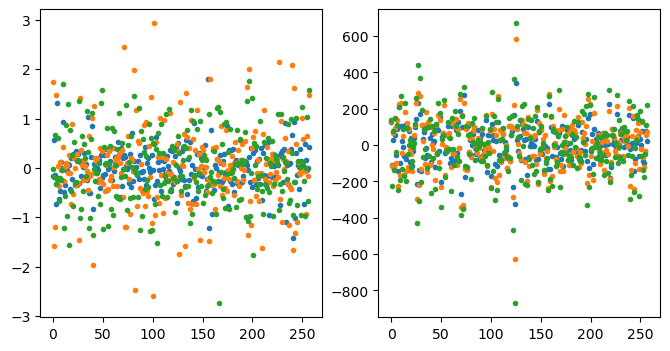

In [29]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
arcn = 201
for arcn in [7000,10000, 12000]:
    axs[0].plot(arc_phase[arcn,:],'.')
    axs[1].plot(arc_phase_uw[arcn,:],'.')

## Set up a sparse system of equations to unwrap
You could try different things, for example you could compute the average inteferometric phase of each arch to get some kind of average deformation, as in the code below, or you could solve for each time step and accumulate the deformation.

In [31]:
neq = arcs.shape[0]
npt = points.shape[0]
eqs = np.concatenate((np.ones(neq+1), -1*np.ones(neq)))
rows = np.concatenate((np.array([0]), 1+np.arange(neq), 1+np.arange(neq)))
cols = np.concatenate((np.array([best_ind]), arcs[:,1], arcs[:,0]))
rows.shape
arc_avg_phase = np.mean(arc_phase, axis=1)
print(arcs.max())
#print(np.concatenate((np.arange(npt), np.arange(npt))).shape)
#print(np.concatenate((arcs[:,1], arcs[:,0])).shape)
A = csr_matrix((eqs,(rows,cols)), shape=(neq+1,npt))
#, shape=(npt,npt)
ls_phase = lsqr(A,np.concatenate((np.array([0]),arc_avg_phase)))[0]



6062


NameError: name 'arc_avg_phase' is not defined